### Library Imports

In [1]:
import pandas as pd
import numpy as np
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
from matplotlib.lines import Line2D

# Modelling
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base import  datetools


warnings.filterwarnings("ignore")

In [2]:
filepath = 'Data/Modelling/PredictionDataset.csv'

df = pd.read_csv(filepath, encoding = 'unicode_escape')
df = df.drop(['Unnamed: 0'], axis = 1)
# Dropping countries whose code is NA
df = df[df['countryCode'].notna()]

# Making the country codes 3 digits long
df.countryCode = df[['countryCode']].astype(int)
codes = list(df.countryCode)
a = ["%03d" % x for x in (codes)]
df['countryCode'] = a
    
df['year']= pd.to_datetime(df['year'], format='%Y')
df.head()

,country,year,record,bioTotal,ecoTotal,countryCode,bioFootprint,ecoFootprint
0,Afghanistan,1961-01-01,cropLand,4.990785e+06,1.010593e+07,002,1.252687e+07,2.536589e+07
1,Afghanistan,1961-01-01,fishingGround,0.000000e+00,9.706928e+02,002,0.000000e+00,3.591563e+02
2,Afghanistan,1961-01-01,grazingLand,6.212850e+06,1.064433e+07,002,2.857911e+06,4.896393e+06
3,Afghanistan,1961-01-01,builtupLand,2.722616e+05,5.445231e+05,002,6.833765e+05,1.366753e+06
4,Afghanistan,1961-01-01,carbon,0.000000e+00,5.596314e+05,002,0.000000e+00,7.051356e+05


### Dataset Preparation

In [4]:
def navalues(data):
    cols = data.columns
    for j in cols:
        for i in range(0,len(data)):
             if data[j][i].isna():
                data[j][i] = data[j][i-1]
                
def scale(df):
    sc = StandardScaler()
    df[['bioTotal', 'ecoTotal', 'bioFootprint', 'ecoFootprint']] = sc.fit_transform(df[['bioTotal', 'ecoTotal', 'bioFootprint', 'ecoFootprint']])
    return df

def reverse_scale(df):
    sc = StandardScaler()
    return sc.inverse_transform(df)

def encode(df):
    if 'country' in df.columns.unique():
        df = df.drop(['country'], axis=1)
    if 'record' in df.columns.unique():
        df = pd.get_dummies(df, columns=["record"])
    return df

def prepare_timeseries(df, record):
    return df.set_index(['year'])

def prepareCountryDf(df, countryCode):
    df = df.loc[df['countryCode'] == countryCode]
    return df

In [5]:
df_others = encode(scale(df))
df_others.index = df_others.year
df_others = df_others.drop(['year'], 1)
df_others

,bioTotal,ecoTotal,countryCode,bioFootprint,ecoFootprint,record_builtupLand,record_carbon,record_cropLand,record_fishingGround,record_forestLand,record_grazingLand
year,,,,,,,,,,,
1961-01-01,-0.128429,-0.139998,002,-0.067686,-0.113729,0,0,1,0,0,0
1961-01-01,-0.200220,-0.183028,002,-0.188002,-0.192250,0,0,0,1,0,0
1961-01-01,-0.110850,-0.137705,002,-0.160552,-0.177094,0,0,0,0,0,1
1961-01-01,-0.196303,-0.180714,002,-0.181438,-0.188020,1,0,0,0,0,0
1961-01-01,-0.200220,-0.180649,002,-0.188002,-0.190068,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01,-0.198170,-0.182060,181,-0.187495,-0.191989,0,0,0,1,0,0
2018-01-01,-0.137533,-0.145716,181,-0.168748,-0.179773,0,0,0,0,0,1
2018-01-01,-0.168524,-0.155124,181,-0.134881,-0.141329,0,0,1,0,0,0


## Prediction Models

### 1. Hist Gradient Bossting Regressor

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_others, test_size=0.2)

X_train = train.iloc[:,[0,2]]
y_train = train["ecoFootprint"]
X_test = test.iloc[:,[0,2]]

In [7]:
from sklearn.ensemble import HistGradientBoostingRegressor

regressor = HistGradientBoostingRegressor(min_samples_leaf=1)
regressor.fit(X_train, y_train)
test["predictions"] = regressor.predict(X_test)

In [8]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.plot(train.index,train["ecoFootprint"], label='train data', color="green")
# ax.plot(test.index,test["ecoFootprint"], label='test data', color="blue")
# ax.scatter(test.index, test["predictions"], label='predictions', color="red", s=75)
# ax.legend(loc="upper left")
# plt.show();

In [9]:
from sklearn.metrics import mean_squared_error
print('MSE = %.4g' % mean_squared_error(test["ecoFootprint"],test["predictions"]))

MSE = 0.2334


### 2. Linear Tree

In [10]:
# !pip install -q --upgrade linear-tree

from lineartree import LinearBoostRegressor
from sklearn.linear_model import LinearRegression

In [11]:
regressor = LinearBoostRegressor(base_estimator=LinearRegression(),
                                 n_estimators = 300, 
                                 max_depth    = 5,
                                 random_state = 42)
regressor.fit(X_train, y_train)
test["predictions"] = regressor.predict(X_test)

In [12]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.plot(train.index,train["ecoFootprint"], label='train data', color="green")
# ax.plot(test.index,test["ecoFootprint"], label='test data', color="blue")
# ax.scatter(test.index, test["predictions"], label='predictions', color="red", s=75)
# ax.legend(loc="upper left")
# plt.show();

In [13]:
print('MSE = %.4g' % mean_squared_error(test["ecoFootprint"],test["predictions"]))

MSE = 0.2347


In [14]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')
# plt.rcParams.update({'font.size': 16})

# !pip install -q ptitprince
# import ptitprince as pt

# mono_font = {'fontname':'monospace'}
# fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# pt.RainCloud(data=train_data, y = "ecoFootprint", bw=0.1, cut=0, hue=['teal'], orient='h', label="training data", palette=['teal'], alpha = .65)
# pt.RainCloud(data=test_data, y = "predictions", bw=0.1, cut=0, orient='h',label="predictions", hue=['crimson'], palette=['crimson'], alpha = .65)
# plt.title("Indoor_temperature_room", fontsize=18, **mono_font)
# plt.xlabel("Temperature")
# legend = plt.legend()
# plt.tick_params(labelleft=False, left=False)
# plt.show()

### 3. Tabular Regression

In [15]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [16]:
# X is all columns except target var and y is target var
X = df_others.drop(["ecoFootprint"], 1)
y = df_others["ecoFootprint"]
y = np.asarray(y).astype('float32')

In [17]:
# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=21)

In [18]:
y_train, y_test, y_val = y_train.astype('float32'), y_test.astype(float), y_val.astype(float)
X_train = np.asarray(X_train).astype('float32')
X_val = np.asarray(X_val).astype('float32')
X_test = np.asarray(X_test).astype('float32')

- The <code> torch.from_numpy </code> module helps to convert the numpy array into a tensor in PyTorch.
- The returned tensor and initial numpy array share the same memory. However, the tensor is not resizeable.
- <code> RegressionDataset </code> is a custom class that uses PyTorch's Dataset module.

In [19]:
class RegressionDataset(Dataset):
    # Initializing the data that we will be using
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
    
    # Gets a sample of the data being passed and constructs the dataset
    # Hence it will loop through the function and create a sample from each instance in the dataset
    # index is the data instance being looped through
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    # Returns the length of the data
    def __len__ (self):
        return len(self.X_data)
    
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

- First, we initialize the model parameters
- Then, making use of Torch's DataLoader module to pass samples in <b> mini batches. </b> This ensures that the data is reshuffled at every epoch to reduce overfitting.

In [20]:
EPOCHS = 150
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [21]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return (x)

    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return (x)

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
###################### OUTPUT ######################
cuda:0

cpu


In [23]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=10, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [24]:
loss_stats = {
    'train': [],
    "val": []
}

In [25]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()

        y_train_pred = model(X_train_batch)

        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))

        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        val_epoch_loss = 0
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)    
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            val_epoch_loss += val_loss.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.65521 | Val Loss: 0.13024
Epoch 002: | Train Loss: 0.03187 | Val Loss: 0.00983
Epoch 003: | Train Loss: 0.00914 | Val Loss: 0.00397
Epoch 004: | Train Loss: 0.00538 | Val Loss: 0.00337
Epoch 005: | Train Loss: 0.00461 | Val Loss: 0.00260
Epoch 006: | Train Loss: 0.00439 | Val Loss: 0.00849
Epoch 007: | Train Loss: 0.00449 | Val Loss: 0.00612
Epoch 008: | Train Loss: 0.00415 | Val Loss: 0.00822
Epoch 009: | Train Loss: 0.00460 | Val Loss: 0.00227
Epoch 010: | Train Loss: 0.00564 | Val Loss: 0.00195
Epoch 011: | Train Loss: 0.00430 | Val Loss: 0.00308
Epoch 012: | Train Loss: 0.00399 | Val Loss: 0.00195
Epoch 013: | Train Loss: 0.00403 | Val Loss: 0.00201
Epoch 014: | Train Loss: 0.00283 | Val Loss: 0.00725
Epoch 015: | Train Loss: 0.00398 | Val Loss: 0.00207
Epoch 016: | Train Loss: 0.00368 | Val Loss: 0.00324
Epoch 017: | Train Loss: 0.00323 | Val Loss: 0.00169
Epoch 018: | Train Loss: 0.00614 | Val Loss: 0.00305
Epoch 019: | Train Loss: 0.00309 | Val Loss: 0

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

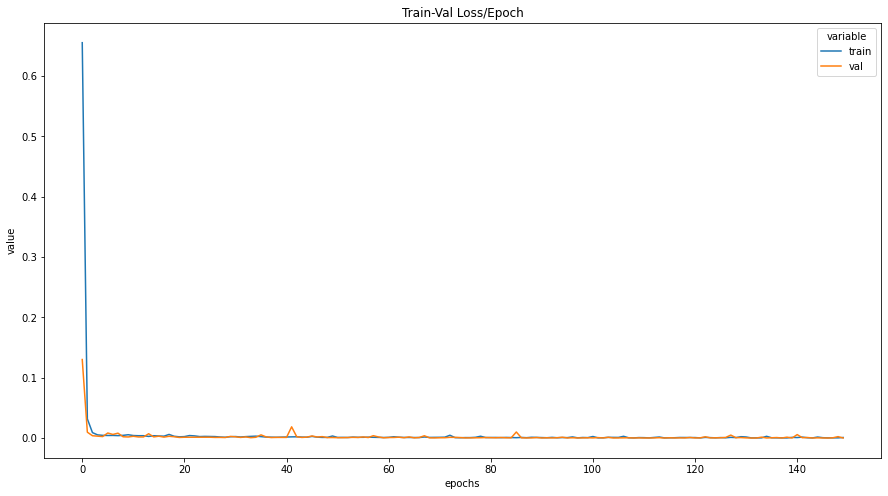

In [26]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

In [27]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [28]:
mse = mean_squared_error(y_test, y_pred_list)
r_square = r2_score(y_test, y_pred_list)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 0.00019035943732544972
R^2 : 0.9998372588629642


#### Predicting for a new row of values

In [29]:
T = [[-0.186135, -0.167322, 211, -0.183676, 0, 0, 0, 0, 0, 1],
    [-0.171125, -0.177002, 211, -0.203476, 0, 0, 0, 0, 0, 1]]

# T = np.array([np.array(xi) for xi in T])
T = RegressionDataset(torch.from_numpy(np.array([np.array(xi) for xi in T])).float(), torch.from_numpy(y_train).float())

t_loader = DataLoader(dataset=T, batch_size=BATCH_SIZE, shuffle=True)

y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in t_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [30]:
y_pred_list

[[-0.1796792894601822, -0.1834317147731781]]

### 4. Random Forest

In [31]:
# X is all columns except target var and y is target var
X = df_others.drop(["ecoFootprint"], 1)
y = df_others["ecoFootprint"]
y = np.asarray(y).astype('float32')

# Split train into train-val
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [32]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 10, random_state = 0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred

array([-0.19146031, -0.19216598, -0.01648922, ..., -0.19174319,
       -0.19219363,  0.05137983])

In [33]:
len(y_test)

8060

In [34]:
mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)

print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 0.00040444018359855714
R^2 : 0.9995876937381284


### 5. Decision Trees

In [35]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth = 1)
tree.fit(X_train, y_train)

y_pred_train = tree.predict(X_test).reshape(-1)

In [36]:
mse = mean_squared_error(y_test, y_pred_train)
r_square = r2_score(y_test, y_pred_train)

print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 0.44230200385051377
R^2 : 0.5490955319935955
